<a href="https://colab.research.google.com/github/indrad123/imagecaptioning/blob/main/fin_msc_mt_evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install datasets
!pip install nusacrowd
!pip install evaluate
!pip install sentencepiece
!pip install sacremoses
!pip install transformers
!pip install rouge_score

  Using cached nusacrowd-0.1.4-py3-none-any.whl (384 kB)
  Using cached loguru-0.7.2-py3-none-any.whl (62 kB)
  Using cached bioc-2.1-py3-none-any.whl (33 kB)
  Using cached black-22.12.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.6 MB)
  Using cached flake8-7.0.0-py2.py3-none-any.whl (57 kB)
  Using cached isort-5.13.2-py3-none-any.whl (92 kB)
  Using cached pre_commit-3.7.1-py2.py3-none-any.whl (204 kB)
  Using cached jsonlines-4.0.0-py3-none-any.whl (8.7 kB)
  Using cached zstandard-0.22.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (5.4 MB)
  Using cached ffmpeg-1.4.tar.gz (5.1 kB)
  Preparing metadata (setup.py) ... done
  Using cached conllu-4.5.3-py2.py3-none-any.whl (16 kB)
  Using cached translate_toolkit-3.13.0-py3-none-any.whl (744 kB)
  Using cached intervaltree-3.1.0.tar.gz (32 kB)
  Preparing metadata (setup.py) ... done
  Using cached docopt-0.6.2.tar.gz (25 kB)
  Preparing metadata (setup.py) ... done
  Using cached mypy_extensions-1.0.

In [ ]:
import pandas as pd
import torch
from torch.nn import DataParallel
from torch.utils.data import DataLoader
from datasets import load_dataset, load_metric
from transformers import MarianMTModel, MarianTokenizer, pipeline

# Load Dataset for Evaluation

In [ ]:
# dataset for evaluation
dataset = load_dataset("SEACrowd/indo_general_mt_en_id", trust_remote_code=True)

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

In [ ]:
dataset


DatasetDict({
    train: Dataset({
        features: ['id', 'src', 'tgt'],
        num_rows: 1821716
    })
    test: Dataset({
        features: ['id', 'src', 'tgt'],
        num_rows: 2000
    })
    validation: Dataset({
        features: ['id', 'src', 'tgt'],
        num_rows: 2000
    })
})

In [ ]:
# Create an empty dataframe with the specified columns
df_eval = pd.DataFrame(columns=["model", "bleu_score", "rouge_score", "meteor_score"])

# Check if a GPU is available and if not, use a CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


pytorch_model.bin:  40%|###9      | 115M/291M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

MarianMTModel(
  (model): MarianModel(
    (shared): Embedding(54796, 512, padding_idx=54795)
    (encoder): MarianEncoder(
      (embed_tokens): Embedding(54796, 512, padding_idx=54795)
      (embed_positions): MarianSinusoidalPositionalEmbedding(512, 512)
      (layers): ModuleList(
        (0-5): 6 x MarianEncoderLayer(
          (self_attn): MarianAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (activation_fn): SiLU()
          (fc1): Linear(in_features=512, out_features=2048, bias=True)
          (fc2): Linear(in_features=2048, out_features=512, bias=True)
          (final_layer_norm): LayerNorm((512,), eps=1e-05

# Marian MT Model

In [ ]:
# Load the Model and Tokenizer
model_name = 'Helsinki-NLP/opus-mt-en-id'
tokenizer = MarianTokenizer.from_pretrained(model_name)
model = MarianMTModel.from_pretrained(model_name)

# Check if multiple GPUs are available
if torch.cuda.device_count() > 1:
    # Use DataParallel to distribute the model across multiple GPUs
    model = DataParallel(model)

# Then move your model to the chosen device
model.to(device)

# Preprocess Your Dataset
def preprocess_function(examples):
    # Tokenize both source and target sentences
    model_inputs = tokenizer(examples['src'], text_target=examples['tgt'], truncation=True, padding='max_length', return_tensors='pt')
    # Include labels in the output
    model_inputs['labels'] = model_inputs['input_ids']
    return model_inputs

encoded_dataset = dataset["test"].map(preprocess_function, batched=True)

# Create a translation pipeline
translator = pipeline("translation_en_to_id", model=model_name, device=0)  # device=0 means use the GPU

# Create a DataLoader for your dataset
# Set batch_size and make sure return value is a dictionary of tensors
# Convert string IDs in the batch to tensors
def collate_fn(batch):
    result = {}
    for key in batch[0]:
        if isinstance(batch[0][key], str):
            # Convert strings to numerical tokens if needed
            result[key] = tokenizer.convert_tokens_to_ids([y[key] for y in batch])
        else:
            result[key] = torch.stack([torch.tensor(y[key]) for y in batch])
    return result

dataloader = DataLoader(encoded_dataset, batch_size=16, collate_fn=collate_fn)

# Store the predictions and actual labels here
predictions, actuals = [], []

# Process the dataset in batches
for batch in dataloader:
    # Convert input_ids and attention_mask to tensors and move them to device
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    labels = batch['labels'].to(device) # Add this line to move labels to the device

    # Generate predictions in batches
    with torch.no_grad():
        output = model.generate(input_ids, attention_mask=attention_mask, max_length=512)

    # Decode predictions and store
    decoded_preds = tokenizer.batch_decode(output, skip_special_tokens=True)
    predictions.extend(decoded_preds)

    # Store actual labels
    actuals.extend(tokenizer.batch_decode(labels, skip_special_tokens=True)) # Decode the labels as well

# MT5 Model

In [ ]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

def translate_MT5(text_en, model_name="acul3/mt5-translate-en-id"):
  tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=False)
  model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

  input_ids = tokenizer(text_en, return_tensors="pt").input_ids

  outputs = model.generate(input_ids)
  translated_text = tokenizer.batch_decode(outputs[0], skip_special_tokens=True, clean_up_tokenization_spaces=False)

  return translated_text

# Score Result

In [ ]:
# Load the metrics
bleu_metric = load_metric('bleu')
rouge_metric = load_metric('rouge')
meteor_metric = load_metric('meteor')

# Prepare data for metrics
predictions_for_metrics = [pred.split() for pred in predictions] # Tokenize predictions
actuals_for_metrics = [[actual.split()] for actual in actuals]    # Tokenize actuals and nest each within a list

# Compute the metrics
bleu_score = bleu_metric.compute(predictions=predictions_for_metrics, references=actuals_for_metrics)
rouge_score = rouge_metric.compute(predictions=predictions, references=actuals)
meteor_score = meteor_metric.compute(predictions=predictions, references=actuals)

# Add a new row to the DataFrame using pd.concat
new_row = pd.DataFrame({"model": [model_name], "bleu_score": [bleu_score], "rouge_score": [rouge_score], "meteor_score": [meteor_score]})
df_eval = pd.concat([df_eval, new_row], ignore_index=True)

# Print the updated DataFrame
print(df_eval)

/usr/local/lib/python3.10/dist-packages/datasets/load.py:759: FutureWarning: The repository for bleu contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.2/metrics/bleu/bleu.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/datasets/load.py:759: FutureWarning: The repository for rouge contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.2/metrics/rouge/rouge.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major r

                        model  \
0                      Model1   
1                      Model2   
2                      Model1   
3                      Model2   
4  Helsinki-NLP/opus-mt-en-id   

                                                                                                                                                                                                                                                               bleu_score  \
0                                                                                                                                                                                                                                                                   0.055   
1                                                                                                                                                                                                                                                                   0.0

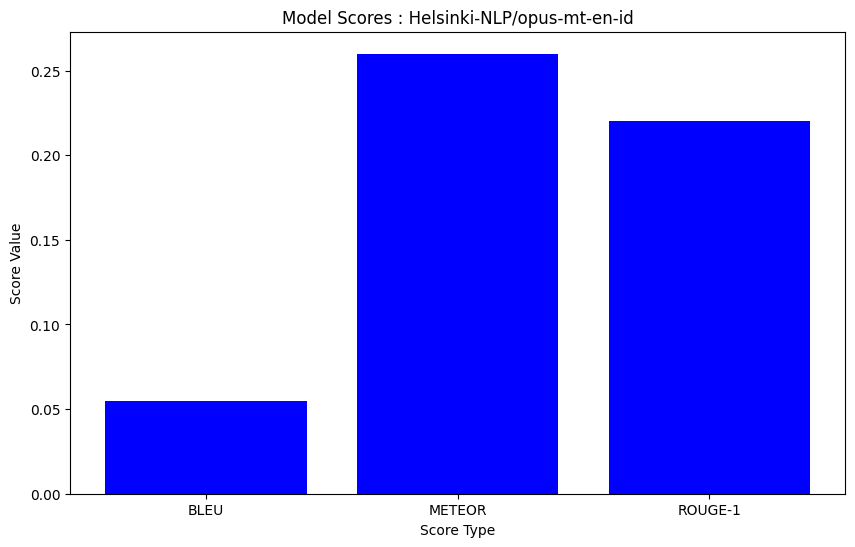

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
# Extract scores from the DataFrame
bleu_score = df_eval['bleu_score'].iloc[0]  # Access the score from the dictionary
meteor_score = df_eval['meteor_score'].iloc[0]
rouge1_score = df_eval['rouge_score'].iloc[0]

scores = [bleu_score, meteor_score, rouge1_score]
score_labels = ['BLEU', 'METEOR', 'ROUGE-1']

# Create bar chart
plt.figure(figsize=(10, 6))
plt.bar(score_labels, scores, color='blue')

plt.xlabel('Score Type')
plt.ylabel('Score Value')
plt.title('Model Scores : ' + model_name)

# Display the plot
plt.show()


# Combine Code

In [4]:
import torch
from torch.utils.data import DataLoader
from transformers import MarianTokenizer, MarianMTModel, AutoTokenizer, AutoModelForSeq2SeqLM, M2M100ForConditionalGeneration, M2M100Tokenizer, MBart50TokenizerFast, MBartForConditionalGeneration
from datasets import load_dataset, load_metric
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Function to load and preprocess the dataset
def load_and_preprocess_dataset(dataset_name):
    dataset = load_dataset(dataset_name, trust_remote_code=True)
    return dataset

def preprocess_function(examples, tokenizer, src_lang=None):
    if src_lang:
        tokenizer.src_lang = src_lang
    model_inputs = tokenizer(examples['src'], text_target=examples['tgt'], truncation=True, padding='max_length', max_length=512, return_tensors='pt')
    return model_inputs

def get_dataloader(encoded_dataset, batch_size=16):
  def collate_fn(batch):
      result = {}
      for key in batch[0]:
          if isinstance(batch[0][key], str):
              # Convert strings to numerical tokens if needed
              result[key] = tokenizer.convert_tokens_to_ids([y[key] for y in batch])
          else:
              result[key] = torch.stack([torch.tensor(y[key]) for y in batch])
      return result

  dataloader = DataLoader(encoded_dataset, batch_size=16, collate_fn=collate_fn)

  # Create DataLoader instance and return it
  # dataloader = DataLoader(encoded_dataset, batch_size=batch_size, collate_fn=collate_fn)
  return dataloader  # Explicitly return the DataLoader

def generate_predictions(dataloader, model, tokenizer, src_lang=None, tgt_lang=None):
    predictions, actuals = [], []

    for batch in dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        if src_lang:
            tokenizer.src_lang = src_lang

        with torch.no_grad():
            if tgt_lang:
              if isinstance(model, MBartForConditionalGeneration):
                generated_tokens = model.generate(input_ids, attention_mask=attention_mask, max_length=512, forced_bos_token_id=tokenizer.lang_code_to_id[tgt_lang])
              elif isinstance(model, M2M100ForConditionalGeneration):
                generated_tokens = model.generate(input_ids, attention_mask=attention_mask, max_length=512, forced_bos_token_id=tokenizer.get_lang_id(tgt_lang))
            else:
                generated_tokens = model.generate(input_ids, attention_mask=attention_mask, max_length=512)

        decoded_preds = tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)
        predictions.extend(decoded_preds)

        decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
        actuals.extend(decoded_labels)

    return predictions, actuals

def load_model_and_tokenizer(model_name, model_type):
    model_tokenizer_map = {
        "marian": (MarianTokenizer, MarianMTModel),
        "mt5": (AutoTokenizer, AutoModelForSeq2SeqLM),
        "m2m100": (M2M100Tokenizer, M2M100ForConditionalGeneration),
        "mbart50": (MBart50TokenizerFast, MBartForConditionalGeneration),
        "nllb200": (AutoTokenizer, AutoModelForSeq2SeqLM),
    }
    if model_type in model_tokenizer_map:
        tokenizer_class, model_class = model_tokenizer_map[model_type]
        tokenizer = tokenizer_class.from_pretrained(model_name)
        model = model_class.from_pretrained(model_name)
        model.to(device)

        if torch.cuda.device_count() > 1:
            model = torch.nn.DataParallel(model)

        return model, tokenizer
    else:
        raise ValueError(f"Model type '{model_type}' not supported.")

def evaluate_model(predictions, actuals, model_name):
    # Load the metrics
    bleu_metric = load_metric('bleu')
    rouge_metric = load_metric('rouge')
    meteor_metric = load_metric('meteor')

    # Prepare data for metrics
    predictions_for_metrics = [pred.split() for pred in predictions] # Tokenize predictions
    actuals_for_metrics = [[actual.split()] for actual in actuals]    # Tokenize actuals and nest each within a list

    # Compute the metrics
    bleu_score = bleu_metric.compute(predictions=predictions_for_metrics, references=actuals_for_metrics)
    rouge_score = rouge_metric.compute(predictions=predictions, references=actuals)
    meteor_score = meteor_metric.compute(predictions=predictions, references=actuals)

    # Extract relevant scores
    bleu_score_value = bleu_score['bleu']
    rouge_score_value = rouge_score['rouge1'].mid.fmeasure  # Assuming we use the f-measure for ROUGE-1
    meteor_score_value = meteor_score['meteor']

    # Create a DataFrame with the results
    df_eval = pd.DataFrame({
        "model": [model_name],
        "bleu_score": [bleu_score_value],
        "rouge_score": [rouge_score_value],
        "meteor_score": [meteor_score_value]
    })

    return df_eval

# Initialize an empty DataFrame to store results
df_eval = pd.DataFrame()

# Define model configurations
models_config = [
    {"model_name": "Helsinki-NLP/opus-mt-en-id", "model_type": "marian"},
    {"model_name": "acul3/mt5-translate-en-id", "model_type": "mt5"},
    {"model_name": "facebook/m2m100_418M", "model_type": "m2m100"},
    {"model_name": "facebook/mbart-large-50-many-to-many-mmt", "model_type": "mbart50"},
    {"model_name": "facebook/nllb-200-distilled-600M", "model_type": "nllb200"},
]

dataset_name = "SEACrowd/indo_general_mt_en_id"
dataset = load_and_preprocess_dataset(dataset_name)

# Process each model configuration
for config in models_config:
    model_name = config['model_name']
    model_type = config['model_type']
    model, tokenizer = load_model_and_tokenizer(model_name, model_type)

    # Set language parameters based on model type
    if model_type == "m2m100":
        src_lang = "en"
        tgt_lang = "id"
    elif model_type == "mbart50":
        src_lang = "en_EN"
        tgt_lang = "id_ID"
    elif model_type == "nllb200":
        src_lang = "en"
        tgt_lang = "id"
    else:
        src_lang = None
        tgt_lang = None

    encoded_dataset = dataset["test"].map(lambda x: preprocess_function(x, tokenizer, src_lang=src_lang), batched=True)
    dataloader = get_dataloader(encoded_dataset)

    predictions, actuals = generate_predictions(dataloader, model, tokenizer, src_lang=src_lang, tgt_lang=tgt_lang)
    eval_results = evaluate_model(predictions, actuals, model_name)

    df_eval = pd.concat([df_eval, eval_results], ignore_index=True)

# Print the updated DataFrame
print(df_eval)

# Plot the scores in a grouped bar chart
fig, ax = plt.subplots(figsize=(12, 6))

# Set the width of each bar
bar_width = 0.2

# Set positions of the bars on the x-axis
r1 = np.arange(len(df_eval))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

# Plotting the bars
ax.bar(r1, df_eval['bleu_score'], color='blue', width=bar_width, edgecolor='grey', label='BLEU')
ax.bar(r2, df_eval['meteor_score'], color='green', width=bar_width, edgecolor='grey', label='METEOR')
ax.bar(r3, df_eval['rouge_score'], color='red', width=bar_width, edgecolor='grey', label='ROUGE-1')

# Add labels to the x-axis
ax.set_xlabel('Models', fontweight='bold')
ax.set_xticks([r + bar_width for r in range(len(df_eval))])
ax.set_xticklabels(df_eval['model'])

# Add labels and title
ax.set_ylabel('Score Value', fontweight='bold')
ax.set_title('Model Evaluation Scores', fontweight='bold')

# Create legend
ax.legend()

# Display the plot
plt.show()


tokenizer_config.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/796k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/801k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.26M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/1.38k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/291M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

<ipython-input-4-ed7543b459e0>:91: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  bleu_metric = load_metric('bleu')
/usr/local/lib/python3.10/dist-packages/datasets/load.py:759: FutureWarning: The repository for bleu contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.2/metrics/bleu/bleu.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


/usr/local/lib/python3.10/dist-packages/datasets/load.py:759: FutureWarning: The repository for rouge contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.2/metrics/rouge/rouge.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


/usr/local/lib/python3.10/dist-packages/datasets/load.py:759: FutureWarning: The repository for meteor contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.2/metrics/meteor/meteor.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


tokenizer_config.json:   0%|          | 0.00/376 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/701 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/4.31M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:560: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/datasets/load.py:759: FutureWarning: The repository for bleu contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.2/metrics/bleu/bleu.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/datasets/load.py:759: FutureWarning: The repository for rouge contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.2/metrics/rouge/rouge.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major r

tokenizer_config.json:   0%|          | 0.00/298 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/3.71M [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/1.14k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/908 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.94G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/233 [00:00<?, ?B/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

KeyError: None

# Correction

In [ ]:
import torch
from torch.utils.data import DataLoader
from transformers import (
    MarianTokenizer, MarianMTModel,
    AutoTokenizer, AutoModelForSeq2SeqLM,
    M2M100ForConditionalGeneration, M2M100Tokenizer,
    MBart50TokenizerFast, MBartForConditionalGeneration
)
from datasets import load_dataset, load_metric
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Function to load and preprocess the dataset
def load_and_preprocess_dataset(dataset_name):
    dataset = load_dataset(dataset_name, trust_remote_code=True)
    return dataset

def preprocess_function(examples, tokenizer, src_lang=None):
    if src_lang:
        tokenizer.src_lang = src_lang
    model_inputs = tokenizer(examples['src'], text_target=examples['tgt'], truncation=True, padding='max_length', max_length=512, return_tensors='pt')
    return model_inputs

def get_dataloader(encoded_dataset, batch_size=16):
    def collate_fn(batch):
        result = {}
        for key in batch[0]:
            if isinstance(batch[0][key], str):
                # Convert strings to numerical tokens if needed
                result[key] = tokenizer.convert_tokens_to_ids([y[key] for y in batch])
            else:
                result[key] = torch.stack([torch.tensor(y[key]) for y in batch])
        return result

    dataloader = DataLoader(encoded_dataset, batch_size=batch_size, collate_fn=collate_fn)
    return dataloader

def generate_predictions(dataloader, model, tokenizer, src_lang=None, tgt_lang=None):
    predictions, actuals = [], []

    for batch in dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        if src_lang:
            tokenizer.src_lang = src_lang

        with torch.no_grad():
            if tgt_lang:
                if isinstance(model, MBartForConditionalGeneration):
                    generated_tokens = model.generate(input_ids, attention_mask=attention_mask, max_length=512, forced_bos_token_id=tokenizer.lang_code_to_id[tgt_lang])
                elif isinstance(model, M2M100ForConditionalGeneration):
                    generated_tokens = model.generate(input_ids, attention_mask=attention_mask, max_length=512, forced_bos_token_id=tokenizer.get_lang_id(tgt_lang))
            else:
                generated_tokens = model.generate(input_ids, attention_mask=attention_mask, max_length=512)

        decoded_preds = tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)
        predictions.extend(decoded_preds)

        decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
        actuals.extend(decoded_labels)

    return predictions, actuals

def load_model_and_tokenizer(model_name, model_type):
    model_tokenizer_map = {
        "marian": (MarianTokenizer, MarianMTModel),
        "mt5": (AutoTokenizer, AutoModelForSeq2SeqLM),
        "m2m100": (M2M100Tokenizer, M2M100ForConditionalGeneration),
        "mbart50": (MBart50TokenizerFast, MBartForConditionalGeneration),
        "nllb200": (AutoTokenizer, AutoModelForSeq2SeqLM),
    }
    if model_type in model_tokenizer_map:
        tokenizer_class, model_class = model_tokenizer_map[model_type]
        tokenizer = tokenizer_class.from_pretrained(model_name)
        model = model_class.from_pretrained(model_name)
        model.to(device)

        if torch.cuda.device_count() > 1:
            model = torch.nn.DataParallel(model)

        return model, tokenizer
    else:
        raise ValueError(f"Model type '{model_type}' not supported.")

def evaluate_model(predictions, actuals, model_name):
    # Load the metrics
    bleu_metric = load_metric('bleu')
    rouge_metric = load_metric('rouge')
    meteor_metric = load_metric('meteor')

    # Prepare data for metrics
    predictions_for_metrics = [pred.split() for pred in predictions] # Tokenize predictions
    actuals_for_metrics = [[actual.split()] for actual in actuals]    # Tokenize actuals and nest each within a list

    # Compute the metrics
    bleu_score = bleu_metric.compute(predictions=predictions_for_metrics, references=actuals_for_metrics)
    rouge_score = rouge_metric.compute(predictions=predictions, references=actuals)
    meteor_score = meteor_metric.compute(predictions=predictions, references=actuals)

    # Extract relevant scores
    bleu_score_value = bleu_score['bleu']
    rouge_score_value = rouge_score['rouge1'].mid.fmeasure  # Assuming we use the f-measure for ROUGE-1
    meteor_score_value = meteor_score['meteor']

    # Create a DataFrame with the results
    df_eval = pd.DataFrame({
        "model": [model_name],
        "bleu_score": [bleu_score_value],
        "rouge_score": [rouge_score_value],
        "meteor_score": [meteor_score_value]
    })

    return df_eval

# Initialize an empty DataFrame to store results
df_eval = pd.DataFrame()

# Define model configurations
models_config = [
    {"model_name": "Helsinki-NLP/opus-mt-en-id", "model_type": "marian"},
    {"model_name": "acul3/mt5-translate-en-id", "model_type": "mt5"},
    {"model_name": "facebook/m2m100_418M", "model_type": "m2m100"},
    {"model_name": "facebook/mbart-large-50-many-to-many-mmt", "model_type": "mbart50"},
    {"model_name": "facebook/nllb-200-distilled-600M", "model_type": "nllb200"},
]

dataset_name = "SEACrowd/indo_general_mt_en_id"
dataset = load_and_preprocess_dataset(dataset_name)

# Process each model configuration
for config in models_config:
    model_name = config['model_name']
    model_type = config['model_type']
    model, tokenizer = load_model_and_tokenizer(model_name, model_type)

    # Set language parameters based on model type
    if model_type == "m2m100":
        src_lang = "en"
        tgt_lang = "id"
    elif model_type == "mbart50":
        src_lang = "en_XX"
        tgt_lang = "id_ID"
    elif model_type == "nllb200":
        src_lang = "eng_Latn"
        tgt_lang = "ind_Latn"
    else:
        src_lang = None
        tgt_lang = None

    if src_lang is not None:
        encoded_dataset = dataset["test"].map(lambda x: preprocess_function(x, tokenizer, src_lang=src_lang), batched=True)
    else:
        encoded_dataset = dataset["test"].map(lambda x: preprocess_function(x, tokenizer), batched=True)

    dataloader = get_dataloader(encoded_dataset)

    predictions, actuals = generate_predictions(dataloader, model, tokenizer, src_lang=src_lang, tgt_lang=tgt_lang)
    eval_results = evaluate_model(predictions, actuals, model_name)

    df_eval = pd.concat([df_eval, eval_results], ignore_index=True)

# Print the updated DataFrame
print(df_eval)

# Plot the scores in a grouped bar chart
fig, ax = plt.subplots(figsize=(12, 6))

# Set the width of each bar
bar_width = 0.2

# Set positions of the bars on the x-axis
r1 = np.arange(len(df_eval))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

# Plotting the bars
ax.bar(r1, df_eval['bleu_score'], color='blue', width=bar_width, edgecolor='grey', label='BLEU')
ax.bar(r2, df_eval['meteor_score'], color='green', width=bar_width, edgecolor='grey', label='METEOR')
ax.bar(r3, df_eval['rouge_score'], color='red', width=bar_width, edgecolor='grey', label='ROUGE-1')

# Add labels to the x-axis
ax.set_xlabel('Models', fontweight='bold')
ax.set_xticks([r + bar_width for r in range(len(df_eval))])
ax.set_xticklabels(df_eval['model'])

# Add labels and title
ax.set_ylabel('Score Value', fontweight='bold')
ax.set_title('Model Evaluation Scores', fontweight='bold')

# Create legend
ax.legend()

# Display the plot
plt.show()


Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [ ]:
df_eval.head()

,model,bleu_score,rouge_score,meteor_score
0,Helsinki-NLP/opus-mt-en-id,0.206703,0.494167,0.463364
1,acul3/mt5-translate-en-id,0.144689,0.516004,0.517606
